In [1]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import hvplot.pandas
from pathlib import Path
import matplotlib.pyplot as plt
import os

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import sqlite3
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

# Data Retreiving from SQL

In [2]:
# Check if the database file exists
if os.path.exists(f"Downloads\\housing_prices.db"):
    print("ok")
else:
    print("not ok") 
# Establish a connection to the database    
conn = sqlite3.connect("Downloads/housing_prices.db")    
    

ok


In [3]:
# Create the SQLite engine
db_path = "Downloads/housing_price.db"
engine = create_engine(f"sqlite:///{db_path}")

# Define table name
table_name = "housing_price"

# Use a raw SQL query instead of read_sql_table()
query = f"SELECT * FROM {table_name}"
housing_price_df = pd.read_sql_query(query, con=engine)

# Display DataFrame
housing_price_df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,58796.0,for_sale,169900,2.0,2.0,NaN,1194249.0,Agawam,Massachusetts,1001.0,892.0,4/30/2019
1,8147.0,for_sale,242000,2.0,2.0,NaN,913299.0,Agawam,Massachusetts,1001.0,1428.0,None
2,22700.0,for_sale,299950,2.0,2.0,NaN,560791.0,Agawam,Massachusetts,1001.0,1659.0,None
3,22700.0,for_sale,239900,3.0,1.0,0.46,849166.0,Agawam,Massachusetts,1001.0,1196.0,None
4,21163.0,for_sale,525000,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,6/25/2014
...,...,...,...,...,...,...,...,...,...,...,...,...
257783,51500.0,for_sale,135000,2.0,1.0,0.20,1347169.0,Ellwood City,Pennsylvania,16117.0,672.0,10/21/2019
257784,83590.0,for_sale,145000,2.0,2.0,0.17,539528.0,Aliquippa,Pennsylvania,15001.0,NaN,11/27/2019
257785,72202.0,for_sale,428900,4.0,3.0,7.10,1435095.0,Ellwood City,Pennsylvania,16117.0,NaN,None
257786,13045.0,for_sale,300000,NaN,NaN,0.14,1762223.0,Beaver,Pennsylvania,15009.0,NaN,None


# Data Cleaning & Normalization prior to Modeling

In [4]:
# Drop rows with any NaN values
housing_price_df = housing_price_df.dropna()
housing_price_df

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
4,21163.0,for_sale,525000,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,6/25/2014
5,67455.0,for_sale,289900,3.0,2.0,0.36,1698080.0,Agawam,Massachusetts,1001.0,1276.0,10/12/2012
11,97400.0,for_sale,384900,3.0,2.0,0.46,1244899.0,Agawam,Massachusetts,1001.0,1476.0,11/20/1986
16,33714.0,for_sale,199999,3.0,2.0,1.76,1745924.0,Agawam,Massachusetts,1001.0,1968.0,9/19/2008
22,22188.0,for_sale,419000,4.0,2.0,2.00,1417448.0,Agawam,Massachusetts,1002.0,1607.0,7/25/2005
...,...,...,...,...,...,...,...,...,...,...,...,...
257775,10642.0,for_sale,169900,3.0,1.0,0.07,1227262.0,Rochester,Pennsylvania,15074.0,1406.0,2/3/2022
257777,16829.0,for_sale,415000,3.0,4.0,0.47,743776.0,Coraopolis,Pennsylvania,15108.0,2750.0,8/13/2020
257781,22611.0,for_sale,95000,3.0,1.0,0.07,1120189.0,Rochester,Pennsylvania,15074.0,1440.0,5/6/2020
257782,83590.0,for_sale,179900,4.0,2.0,0.18,1607723.0,Ellwood City,Pennsylvania,16117.0,1970.0,3/23/2021


In [5]:
# Calculate the number of duplicate rows
duplicates = housing_price_df.duplicated().sum()
duplicates

0

In [6]:
# Display a summery of DataFrame
housing_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86633 entries, 4 to 257783
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brokered_by     86633 non-null  float64
 1   status          86633 non-null  object 
 2   price           86633 non-null  int64  
 3   bed             86633 non-null  float64
 4   bath            86633 non-null  float64
 5   acre_lot        86633 non-null  float64
 6   street          86633 non-null  float64
 7   city            86633 non-null  object 
 8   state           86633 non-null  object 
 9   zip_code        86633 non-null  float64
 10  house_size      86633 non-null  float64
 11  prev_sold_date  86633 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 8.6+ MB


In [7]:
# Drop the "status" column
housing_price_df.drop("status", axis=1 , inplace=True)
housing_price_df.reset_index(drop=True, inplace=True)
housing_price_df

C:\Users\iandh\AppData\Local\Temp\ipykernel_28628\982847517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_price_df.drop("status", axis=1 , inplace=True)


,brokered_by,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,21163.0,525000,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,6/25/2014
1,67455.0,289900,3.0,2.0,0.36,1698080.0,Agawam,Massachusetts,1001.0,1276.0,10/12/2012
2,97400.0,384900,3.0,2.0,0.46,1244899.0,Agawam,Massachusetts,1001.0,1476.0,11/20/1986
3,33714.0,199999,3.0,2.0,1.76,1745924.0,Agawam,Massachusetts,1001.0,1968.0,9/19/2008
4,22188.0,419000,4.0,2.0,2.00,1417448.0,Agawam,Massachusetts,1002.0,1607.0,7/25/2005
...,...,...,...,...,...,...,...,...,...,...,...
86628,10642.0,169900,3.0,1.0,0.07,1227262.0,Rochester,Pennsylvania,15074.0,1406.0,2/3/2022
86629,16829.0,415000,3.0,4.0,0.47,743776.0,Coraopolis,Pennsylvania,15108.0,2750.0,8/13/2020
86630,22611.0,95000,3.0,1.0,0.07,1120189.0,Rochester,Pennsylvania,15074.0,1440.0,5/6/2020
86631,83590.0,179900,4.0,2.0,0.18,1607723.0,Ellwood City,Pennsylvania,16117.0,1970.0,3/23/2021


# Visualizations

C:\Users\iandh\AppData\Local\Temp\ipykernel_28628\614430126.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_state_price.index, y=df_state_price.values, palette='viridis')


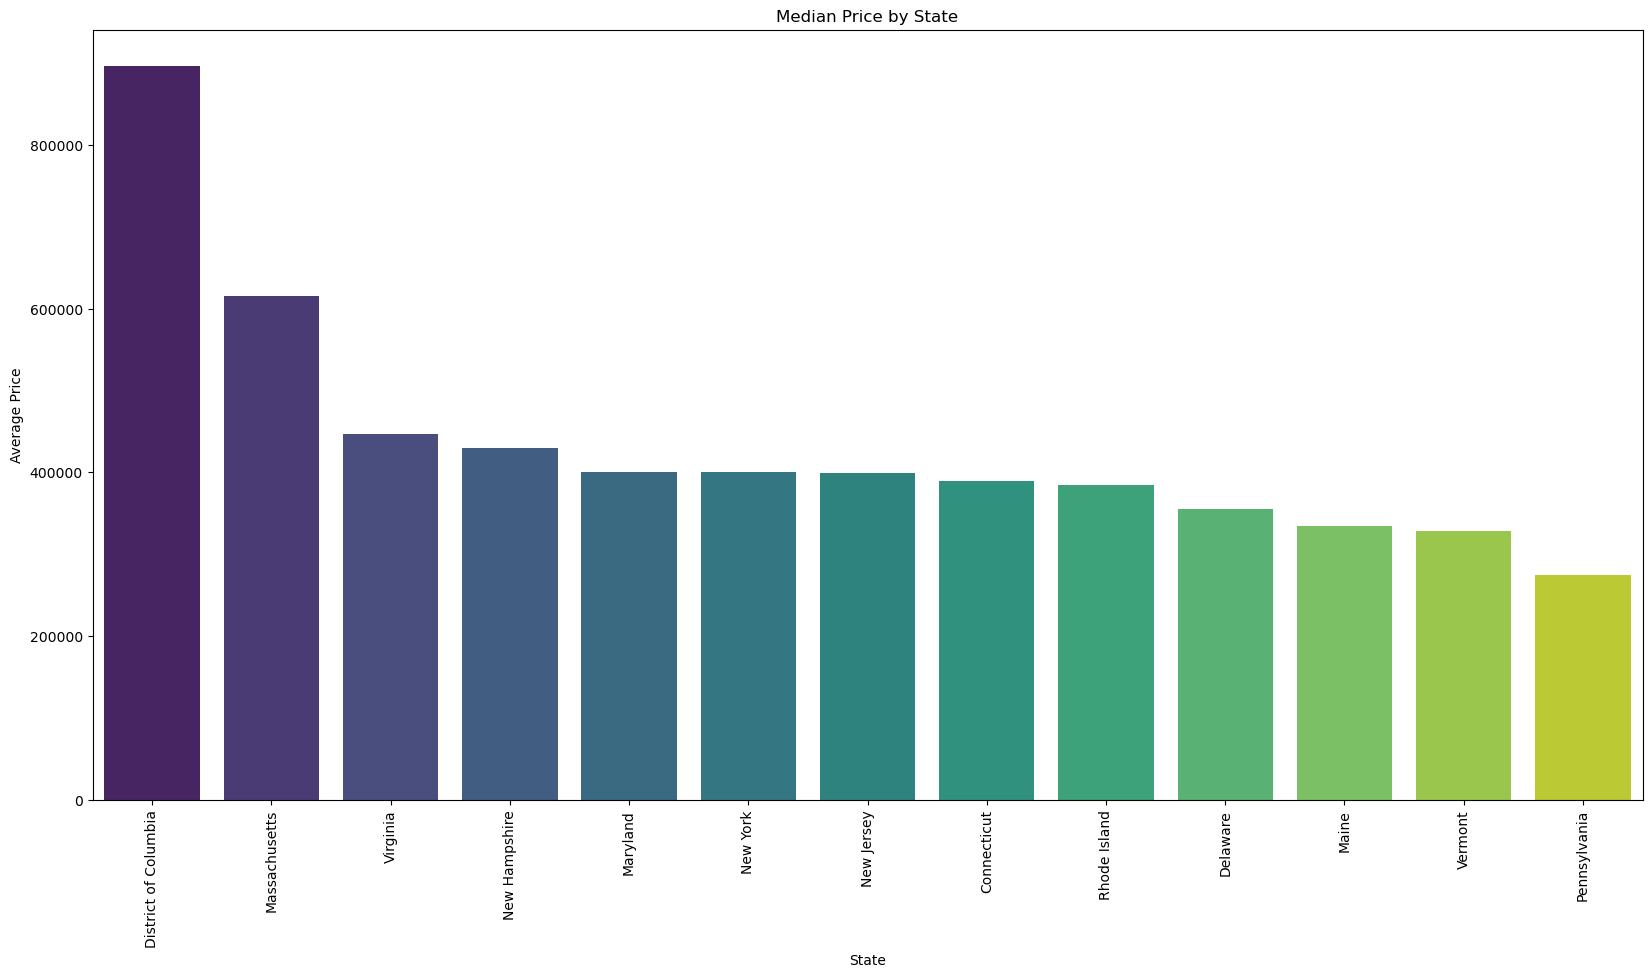

In [8]:
df_state_price = housing_price_df.groupby('state')['price'].median().sort_values(ascending = False)

plt.figure(figsize=(20, 10))
sns.barplot(x=df_state_price.index, y=df_state_price.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Median Price by State')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.show()

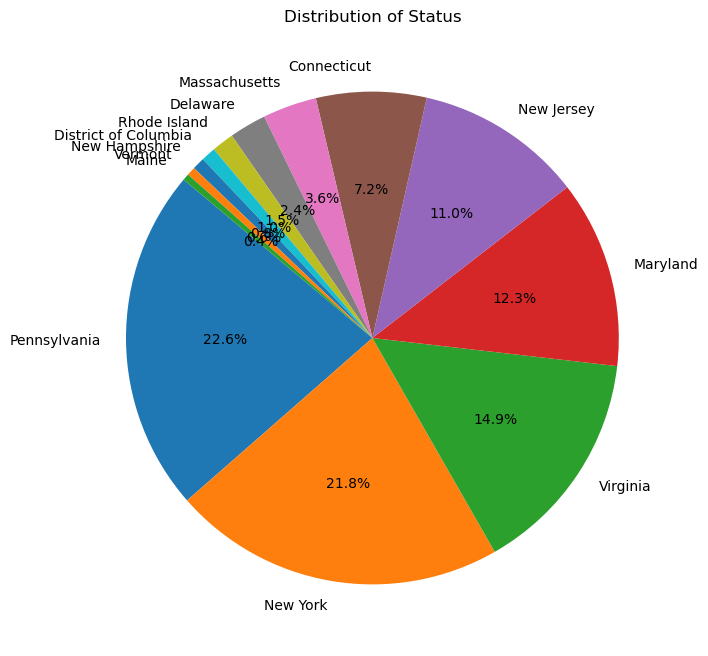

In [9]:
status_counts = housing_price_df['state'].value_counts()

plt.figure(figsize=(8, 8))  # Adjust figure size
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Distribution of Status')

plt.show()

# Deep Data cleaning

In [10]:
# Create dummy variables for 'city' and 'state' columns
housing_price_df = pd.get_dummies(housing_price_df, columns = ['city', 'state'])
housing_price_df

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size,prev_sold_date,city_Aaronsburg,...,state_Maine,state_Maryland,state_Massachusetts,state_New Hampshire,state_New Jersey,state_New York,state_Pennsylvania,state_Rhode Island,state_Vermont,state_Virginia
0,21163.0,525000,3.0,3.0,0.45,1813270.0,1001.0,2314.0,6/25/2014,False,...,False,False,True,False,False,False,False,False,False,False
1,67455.0,289900,3.0,2.0,0.36,1698080.0,1001.0,1276.0,10/12/2012,False,...,False,False,True,False,False,False,False,False,False,False
2,97400.0,384900,3.0,2.0,0.46,1244899.0,1001.0,1476.0,11/20/1986,False,...,False,False,True,False,False,False,False,False,False,False
3,33714.0,199999,3.0,2.0,1.76,1745924.0,1001.0,1968.0,9/19/2008,False,...,False,False,True,False,False,False,False,False,False,False
4,22188.0,419000,4.0,2.0,2.00,1417448.0,1002.0,1607.0,7/25/2005,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86628,10642.0,169900,3.0,1.0,0.07,1227262.0,15074.0,1406.0,2/3/2022,False,...,False,False,False,False,False,False,True,False,False,False
86629,16829.0,415000,3.0,4.0,0.47,743776.0,15108.0,2750.0,8/13/2020,False,...,False,False,False,False,False,False,True,False,False,False
86630,22611.0,95000,3.0,1.0,0.07,1120189.0,15074.0,1440.0,5/6/2020,False,...,False,False,False,False,False,False,True,False,False,False
86631,83590.0,179900,4.0,2.0,0.18,1607723.0,16117.0,1970.0,3/23/2021,False,...,False,False,False,False,False,False,True,False,False,False


In [11]:
# Display the data types of the first 15 columns
housing_price_df.dtypes.head(15)

brokered_by         float64
price                 int64
bed                 float64
bath                float64
acre_lot            float64
street              float64
zip_code            float64
house_size          float64
prev_sold_date       object
city_Aaronsburg        bool
city_Abbottstown       bool
city_Abell             bool
city_Aberdeen          bool
city_Abingdon          bool
city_Abington          bool
dtype: object

In [12]:
# Print the number of missing values in each column
print(housing_price_df.isnull().sum())

brokered_by           0
price                 0
bed                   0
bath                  0
acre_lot              0
                     ..
state_New York        0
state_Pennsylvania    0
state_Rhode Island    0
state_Vermont         0
state_Virginia        0
Length: 4227, dtype: int64


In [13]:
# Ensure the 'prev_sold_date' column is in datetime format
housing_price_df['prev_sold_date'] = pd.to_datetime(housing_price_df['prev_sold_date'])

# Define the start and end dates for filtering
start_date = '2018-01-01'
end_date = '2023-12-31'

# Filter the DataFrame to include only rows within the specified date range
filtered_df = housing_price_df[(housing_price_df['prev_sold_date'] >= start_date) & (housing_price_df['prev_sold_date'] <= end_date)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size,prev_sold_date,city_Aaronsburg,...,state_Maine,state_Maryland,state_Massachusetts,state_New Hampshire,state_New Jersey,state_New York,state_Pennsylvania,state_Rhode Island,state_Vermont,state_Virginia
0,62476.0,275000,3.0,2.0,0.16,1308332.0,1002.0,1280.0,2021-08-19,False,...,False,False,True,False,False,False,False,False,False,False
1,53016.0,139000,3.0,2.0,0.05,317473.0,1040.0,1644.0,2018-01-18,False,...,False,False,True,False,False,False,False,False,False,False
2,56729.0,289900,5.0,2.0,0.15,1314394.0,1020.0,2316.0,2020-09-28,False,...,False,False,True,False,False,False,False,False,False,False
3,7554.0,279900,3.0,1.0,0.13,915051.0,1040.0,1456.0,2019-10-21,False,...,False,False,True,False,False,False,False,False,False,False
4,71852.0,400000,4.0,3.0,0.46,242275.0,1075.0,2108.0,2021-09-21,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24357,10642.0,169900,3.0,1.0,0.07,1227262.0,15074.0,1406.0,2022-02-03,False,...,False,False,False,False,False,False,True,False,False,False
24358,16829.0,415000,3.0,4.0,0.47,743776.0,15108.0,2750.0,2020-08-13,False,...,False,False,False,False,False,False,True,False,False,False
24359,22611.0,95000,3.0,1.0,0.07,1120189.0,15074.0,1440.0,2020-05-06,False,...,False,False,False,False,False,False,True,False,False,False
24360,83590.0,179900,4.0,2.0,0.18,1607723.0,16117.0,1970.0,2021-03-23,False,...,False,False,False,False,False,False,True,False,False,False


# Model Implementation 

In [14]:
# Prepare the feature matrix (X)
X = filtered_df.drop(['price', 'prev_sold_date'], axis=1)
# Prepare the target variable (y)
y = filtered_df['price']

In [15]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Initialize the StandardScaler
# Fit the scaler to the training data and transform it
# Transform the test data using the fitted scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Initialize and train model ( Decition Tree Regression )
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 445504151726.4453
R-squared: 0.3581217135453698


In [19]:
# Initialize and train model ( KNN Regeresion )
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 256608374796.26688
R-squared: 0.6302810124982322


In [20]:
# Initialize and train model (boosting Regression)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 212857605926.0693
R-squared: 0.6933167181019786


In [21]:
# Define base models (stacking overall models)
estimators = [
    ('dt', DecisionTreeRegressor()),
    ('knn', KNeighborsRegressor()),
    ('gbr', GradientBoostingRegressor())
]

# Create the stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor())

# Fit the stacking model to the training data
stacking_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

KeyboardInterrupt: 

In [23]:
# Create a DataFrame
data = filtered_df
prj4_df = pd.DataFrame(data)

# Save to CSV
prj4_df.to_csv("model_optimization_results.csv", index=False)